<a href="https://colab.research.google.com/github/masalha-alaa/cifar10-keras/blob/master/cifar10_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import callbacks, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# %matplotlib inline

SEED = 42

In [31]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('Running on GPU')
else:
    print('Running on CPU')

Running on GPU


# Load the dataset

In [32]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Split to training / test sets (we'll let keras make a validation set automatically from the training set)
x_train, y_train = shuffle(x_train, y_train, random_state=SEED)  # shuffle in unison
x_test, y_test = shuffle(x_test, y_test, random_state=SEED)  # shuffle in unison
y_train_cat, y_test_cat = to_categorical(y_train), to_categorical(y_test)
print(f'Classes:')
classes_lbls, classes_cnts = np.unique(y_train, return_counts=True)  # => data is balanced. 5K from each class
NUM_CLASSES = len(classes_lbls)
print(classes_lbls)
print(classes_cnts)

Classes:
[0 1 2 3 4 5 6 7 8 9]
[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]


In [33]:
classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

def lbl_code_to_class(label):
    return classes.get(label)

def class_to_lbl_code(class_name):
    for k,v in classes.items():
        if v == class_name:
            return k
    return None

y_train_lbls, y_test_lbls = np.array(list(map(lbl_code_to_class, y_train.flatten()))), np.array(list(map(lbl_code_to_class, y_test.flatten())))

## Peek at the data

Training data: 50000
Test data: 10000
Image shape: (32, 32, 3), Type: <class 'numpy.ndarray'>, Pixel type: <class 'numpy.uint8'>
Examples:


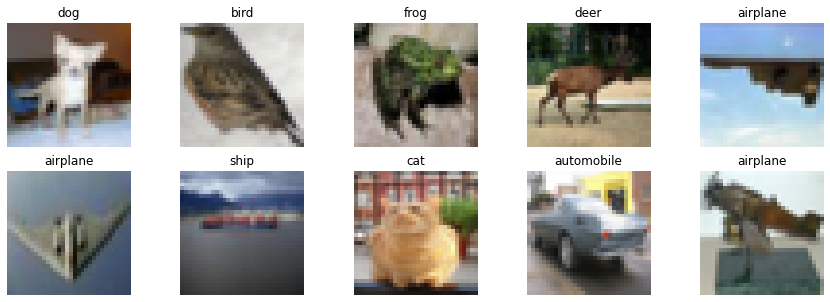

In [34]:
SAMPLE_IMG_IDS = np.random.randint(0, min(len(y_test), len(y_train)), 10)

print(f'Training data: {len(x_train)}')
print(f'Test data: {len(x_test)}')
IMAGE_SHAPE = x_train[0].shape
print(f'Image shape: {IMAGE_SHAPE}, Type: {type(x_train[0])}, Pixel type: {type(x_train[0][0][0][0])}')

print('Examples:')
fig = plt.figure(figsize=(15, 5))
fig.tight_layout(pad=1.0)
for i,idx in enumerate(SAMPLE_IMG_IDS):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[idx])
    plt.title(y_train_lbls[idx])
    plt.axis(False)

plt.show()

In [35]:
# Scale by dividing by 255 or using a scaler
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Model

In [36]:
BATCH_SIZE = 64
EPOCHS = 70
VAL_SPLIT = 0.15

# y = to_categorical(y_train, NUM_CLASSES)
# Some info about categorical_crossentropy / sparse_categorical_crossentropy etc.:
# https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy
# https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c

early_stopping_callback = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

model = keras.Sequential([
    keras.layers.InputLayer(IMAGE_SHAPE),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPool2D(2),
    layers.Dropout(0.3),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPool2D(2),
    layers.Dropout(0.3),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPool2D(2),
    layers.Dropout(0.3),

    layers.Flatten(),

    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

print(model.summary(), end='\n\n')

loss = keras.losses.SparseCategoricalCrossentropy()
# loss = keras.losses.CategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)        

In [37]:
AUGMENT = True

if AUGMENT:
    # With Augmentation
    train_datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,
                                       validation_split=0.15) # set validation split

    train_generator = train_datagen.flow(
        x_train,
        tf.reshape(y_train, (-1)),  # needed because we used SparseCategoricalCrossentropy
        batch_size=BATCH_SIZE,
        subset='training') # set as training data

    validation_generator = train_datagen.flow(
        x_train,
        tf.reshape(y_train, (-1)),  # needed because we used SparseCategoricalCrossentropy
        batch_size=BATCH_SIZE,
        subset='validation') # set as validation data

    history = model.fit(
        train_generator,
        validation_data = validation_generator,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping_callback, reduce_lr_callback],
        epochs = EPOCHS)
else:
    # Without Augmentation
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[early_stopping_callback, reduce_lr_callback],
        verbose=2,
    )

Epoch 1/60
665/665 [==============================] - 21s 31ms/step - loss: 1.6937 - accuracy: 0.3684 - val_loss: 1.4784 - val_accuracy: 0.4643
Epoch 2/60
665/665 [==============================] - 20s 31ms/step - loss: 1.3847 - accuracy: 0.4979 - val_loss: 1.2906 - val_accuracy: 0.5291
Epoch 3/60
665/665 [==============================] - 20s 31ms/step - loss: 1.2566 - accuracy: 0.5522 - val_loss: 1.0896 - val_accuracy: 0.6020
Epoch 4/60
665/665 [==============================] - 20s 31ms/step - loss: 1.1879 - accuracy: 0.5761 - val_loss: 1.0297 - val_accuracy: 0.6315
Epoch 5/60
665/665 [==============================] - 20s 31ms/step - loss: 1.1243 - accuracy: 0.6012 - val_loss: 0.9884 - val_accuracy: 0.6408
Epoch 6/60
665/665 [==============================] - 20s 31ms/step - loss: 1.0844 - accuracy: 0.6158 - val_loss: 0.9787 - val_accuracy: 0.6515
Epoch 7/60
665/665 [==============================] - 20s 30ms/step - loss: 1.0503 - accuracy: 0.6309 - val_loss: 1.0386 - val_accuracy:

In [38]:
model.evaluate(x_test, tf.reshape(y_test, (-1)), batch_size=BATCH_SIZE, verbose=2)

157/157 - 1s - loss: 0.5864 - accuracy: 0.7960


[0.586446225643158, 0.7960000038146973]

(0.0, 1.0)

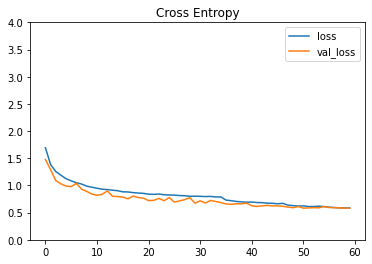

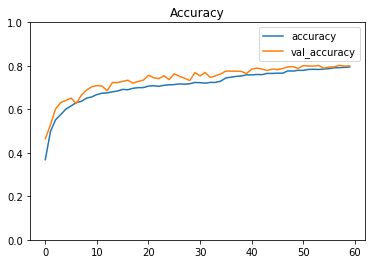

In [39]:
history_df = pd.DataFrame(history.history)
loss_ax = history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross Entropy")
acc_ax = history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='Accuracy')
loss_ax.set_ylim(0, 4)
acc_ax.set_ylim(0, 1)